# 선형 변환의 이해: 행렬과 공간 변형

선형대수학에서 가장 중요한 개념 중 하나인 선형 변환과 행렬의 관계에 대해 알아보겠습니다. 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import matplotlib.font_manager as fm
from matplotlib.animation import FuncAnimation

# 시스템에 설치된 한글 폰트 찾기
font_list = [font.name for font in fm.fontManager.ttflist]
korean_fonts = [f for f in font_list if 'Gothic' in f or 'Malgun' in f or 'Nanum' in f or 'Gulim' in f]

# 한글 폰트 설정 (발견된 폰트 중 하나 선택)
if korean_fonts:
    plt.rcParams['font.family'] = korean_fonts[0]
else:
    print("한글 폰트를 찾을 수 없습니다. 폰트를 설치해 주세요.")

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
# 수학 기호 깨짐 방지 
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'


# 3D 화살표를 그리기 위한 클래스 정의 (개선된 버전)
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)


# 벡터 스타일 상수 정의 (시각적 일관성을 위해)
BASIS_VECTOR_WIDTH = 0.01  # 기저 벡터는 매우 두껍게
MAIN_VECTOR_WIDTH = 0.006  # 주요 벡터는 중간 두께
DERIVED_VECTOR_WIDTH = 0.003  # 파생 벡터는 얇게

# 기저 벡터 색상 체계 변경 - 변환 전후로 구분
# 변환 전 기저 벡터들은 서로 비슷한 색상 (빨간색 계열)
ORIGINAL_I_COLOR = '#CC0000'  # 진한 빨간색 (원본 i 벡터)
ORIGINAL_J_COLOR = '#FF3333'  # 밝은 빨간색 (원본 j 벡터)

# 변환 후 기저 벡터들은 서로 비슷한 색상 (파란색 계열)
TRANSFORMED_I_COLOR = '#0077CC'  # 파란색 (변환된 i 벡터)
TRANSFORMED_J_COLOR = '#0055AA'  # 진한 파란색 (변환된 j 벡터)

# 격자선 색상 (변환 전후로 구분)
ORIGINAL_GRID_COLOR = '#FFCCCC'  # 연한 빨간빛 (변환 전 격자선)
TRANSFORMED_GRID_COLOR = '#99CCFF'  # 연한 파랑빛 (변환 후 격자선)

# 2D 벡터를 화살표로 그리는 함수 (개선된 버전)
def plot_vector2d(vector, origin=[0, 0], color='b', label=None, width=0.005,
                  linestyle=None, alpha=1.0, is_basis=False, zorder=None, head_width=0.05):
    """
    2D 벡터를 화살표로 그리는 함수
    
    Parameters:
    -----------
    vector: 그릴 벡터
    origin: 벡터의 시작점
    color: 화살표 색상
    label: 벡터 레이블
    width: 화살표 두께
    linestyle: 선 스타일 (주의: quiver에서는 지원되지 않으므로 무시됩니다)
    alpha: 투명도
    is_basis: 기저 벡터 여부 (True이면 강조됨)
    zorder: 그리기 순서 (높을수록 앞에 그려짐)
    head_width: 화살표 머리 크기
    """
    # 기저 벡터인 경우 자동으로 두께 증가 및 zorder 설정
    if is_basis and width == 0.005:  # 기본값일 경우만 조정
        width = BASIS_VECTOR_WIDTH

    # zorder가 설정되지 않았으면, 기저 벡터는 앞에 표시
    if zorder is None:
        zorder = 3 if is_basis else 2

    # 주의: quiver에서는 linestyle이 직접 지원되지 않습니다
    plt.quiver(origin[0], origin[1], vector[0], vector[1],
               angles='xy', scale_units='xy', scale=1, color=color,
               width=width, label=label,
               alpha=alpha, zorder=zorder, headwidth=1.5)

## 선형 변환이란 무엇인가?

먼저 '변환(transformation)'이라는 용어부터 이해해 봅시다. 변환은 사실 함수(function)의 다른 표현입니다. 입력값을 받아 출력값을 내놓는 관계를 의미합니다. 선형대수학에서는 특히 벡터를 입력받아 다른 벡터를 출력하는 변환에 관심을 둡니다.

함수 대신 변환이라는 용어를 사용하는 이유는 무엇일까요? 이는 우리가 이 관계를 시각적으로 '움직임'으로 이해하도록 유도하기 위함입니다. 즉, 입력 벡터가 출력 벡터로 '이동'한다고 생각하는 것이죠.

## 선형 변환 조건 

모든 변환이 선형인 것은 아닙니다. 선형 변환은 두 가지 중요한 특성을 가지고 있습니다.

1. **모든 직선은 직선으로 유지되어야 합니다** (곡선이 되면 안 됨)
2. **원점(0,0)은 그 자리에 고정되어야 합니다**

좌표계를 구성한 직선들은 서로 평행하며 균등한 간격을 유지해야합니다. 


## 선형 변환의 수학적 설명

선형 변환을 어떻게 수치적으로 설명할 수 있을까요? 2차원에서의 선형 변환은 단 4개의 숫자로 완전히 설명할 수 있습니다.

이를 이해하기 위해, 기저 벡터(basis vectors)인 i-hat(1,0)과 j-hat(0,1)이 어디로 이동하는지만 알면 된다는 사실에 주목합시다. 이 두 벡터의 이동만 알면 다른 모든 벡터의 이동을 예측할 수 있습니다.

예를 들어, 벡터 v(-1,2)는 -1×i-hat + 2×j-hat으로 표현할 수 있습니다. 선형 변환 후에도 이 관계는 유지됩니다. 즉, v는 (변환된 i-hat)×(-1) + (변환된 j-hat)×2로 이동합니다.

위의 예시에서, i-hat은 (1,-2)로, j-hat은 (3,0)으로 변환되었습니다. 벡터 v(-1,2)는 다음과 같이 변환됩니다.

```
v' = (-1) × (1,-2) + 2 × (3,0)
   = (-1,-2) + (6,0)
   = (5,-2)
```

이는 어떤 벡터 (x,y)든 변환 후에는 `(x × (변환된 i-hat) + y × (변환된 j-hat))`이 된다는 것을 보여줍니다.

## 행렬과 선형 변환의 관계

이제 행렬이 등장합니다. 2×2 행렬은 정확히 이 4개의 숫자(변환된 i-hat과 j-hat의 좌표)를 담는 방법입니다.

```
[ a  b ]
[ c  d ]
```

여기서:
- 첫 번째 열 [a,c]는 i-hat이 변환된 위치
- 두 번째 열 [b,d]는 j-hat이 변환된 위치

이 행렬에 벡터 [x,y]를 곱하면, 그 벡터가 변환 후 어디로 이동하는지 계산할 수 있습니다:

```
[ a  b ] × [ x ] = [ ax + by ]
[ c  d ]   [ y ]   [ cx + dy ]
```

이것이 바로 행렬-벡터 곱셈의 의미입니다.
단순한 계산 공식이 아니라, 벡터가 변환 후 어디로 이동하는지를 알려주는 것입니다.

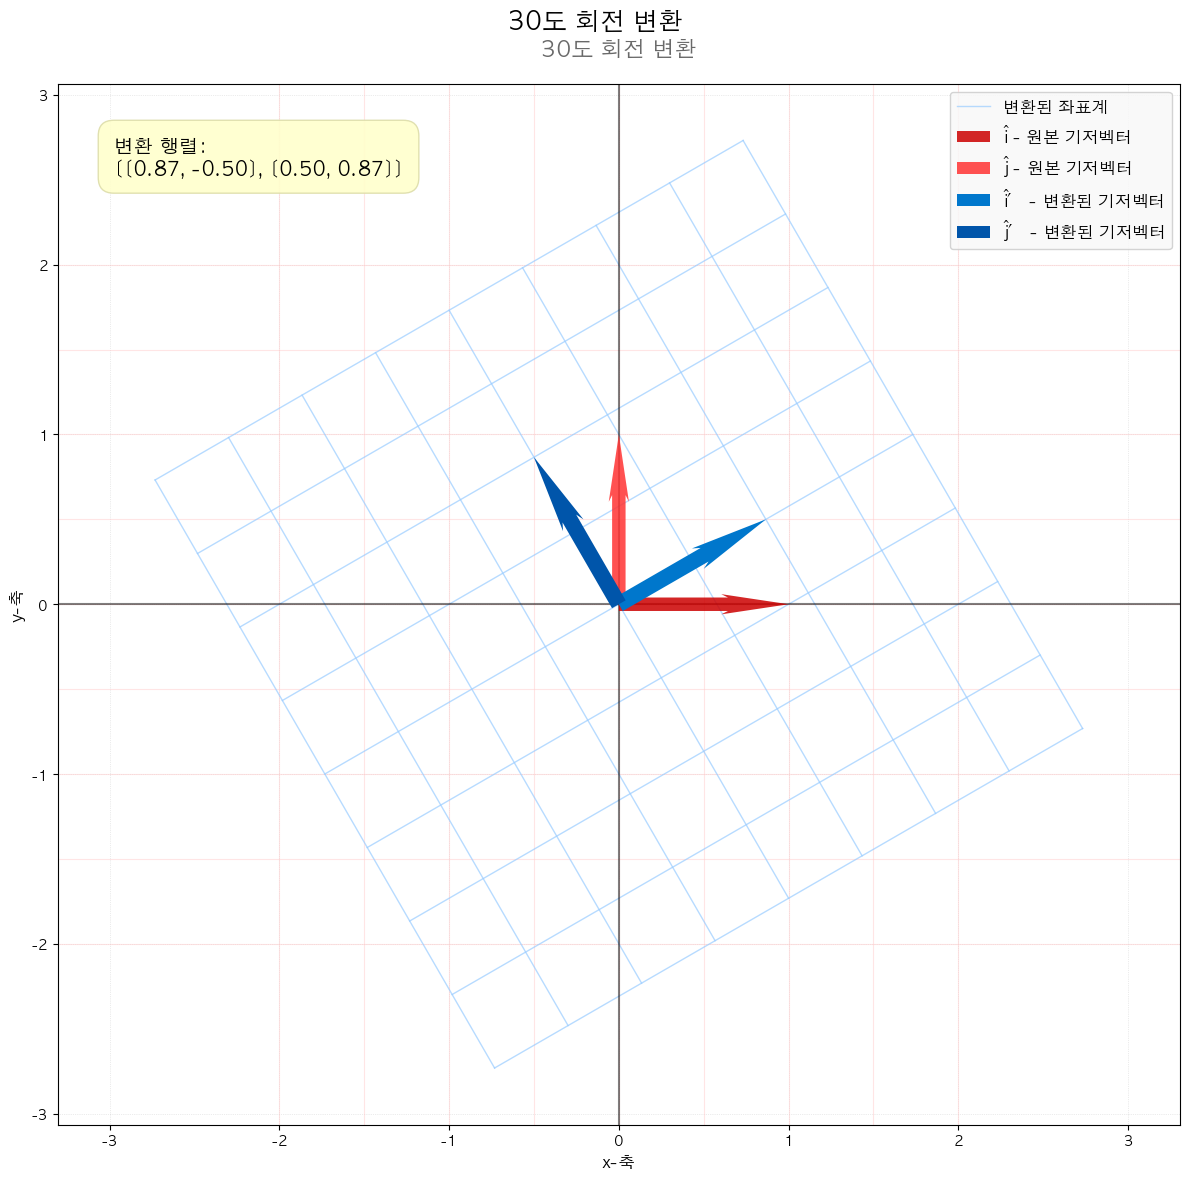

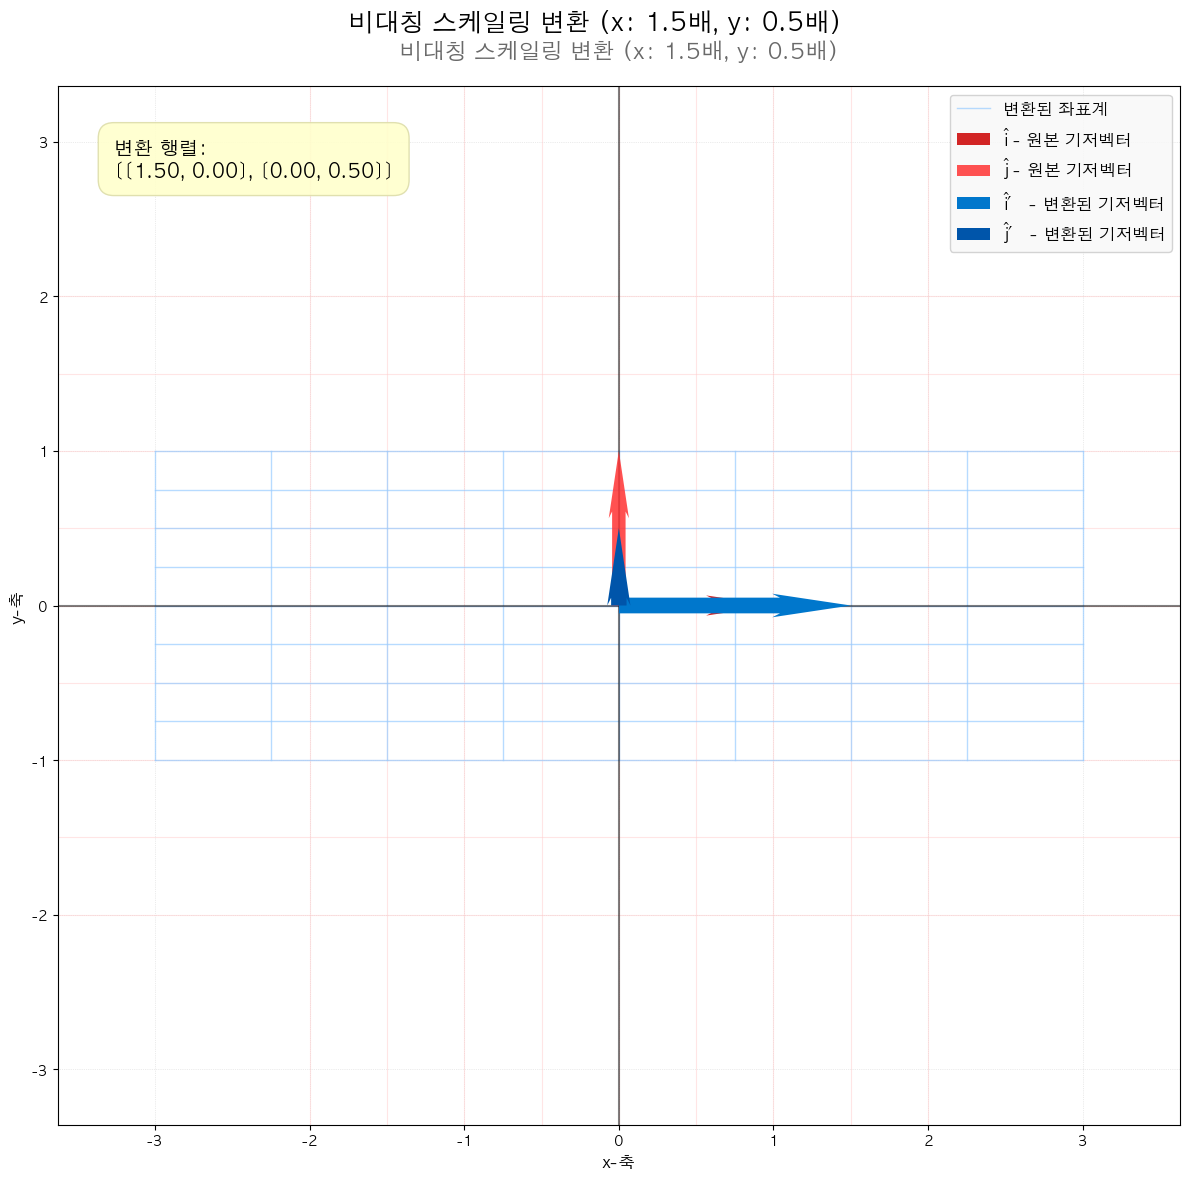

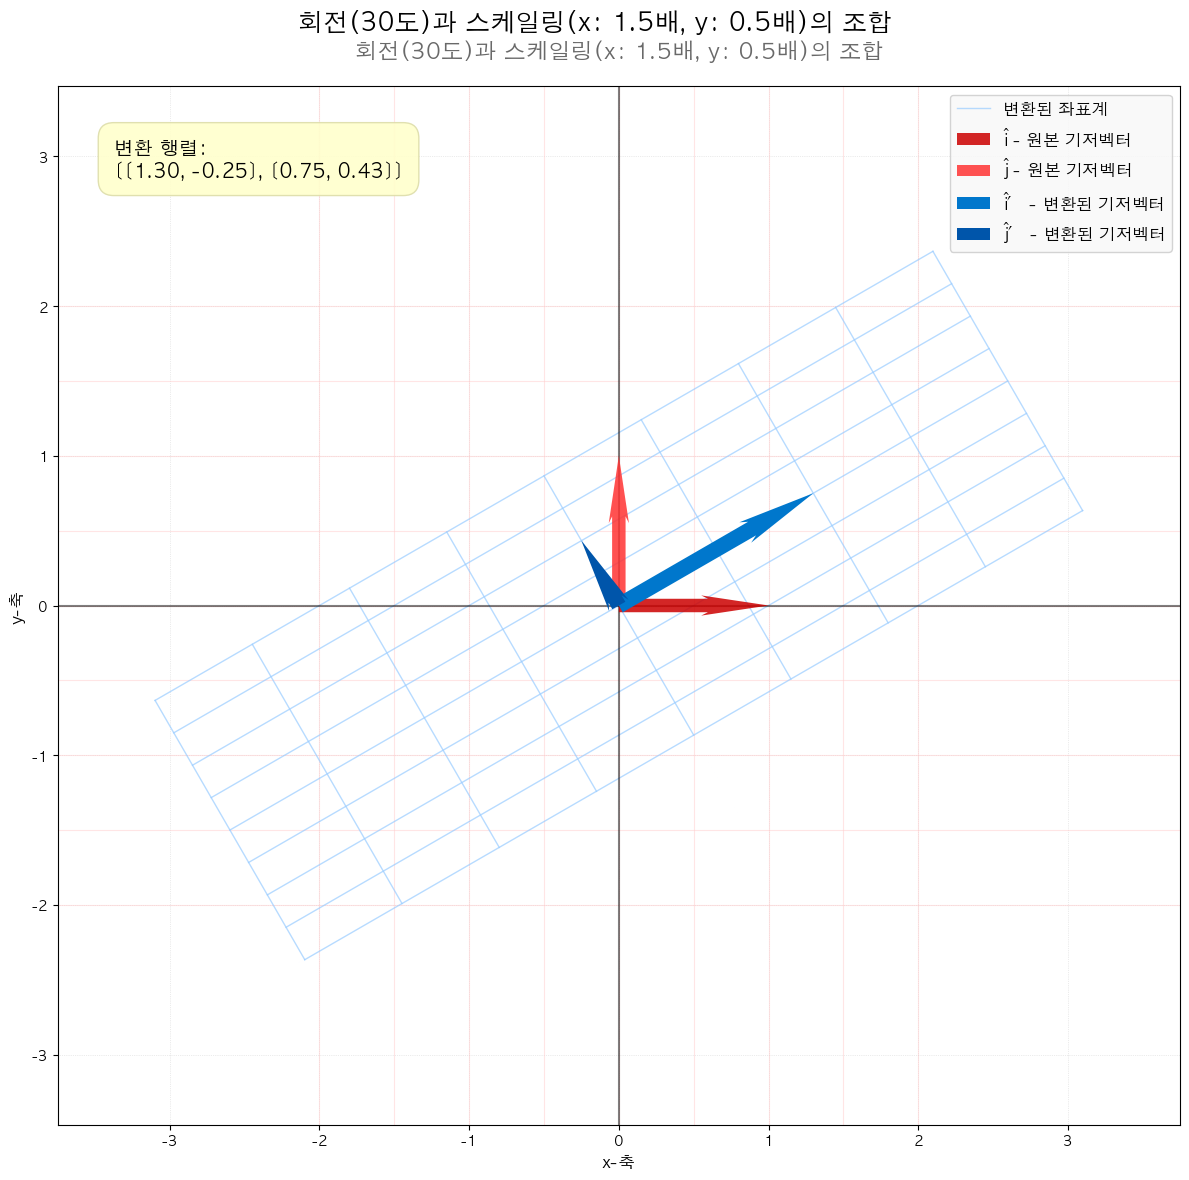

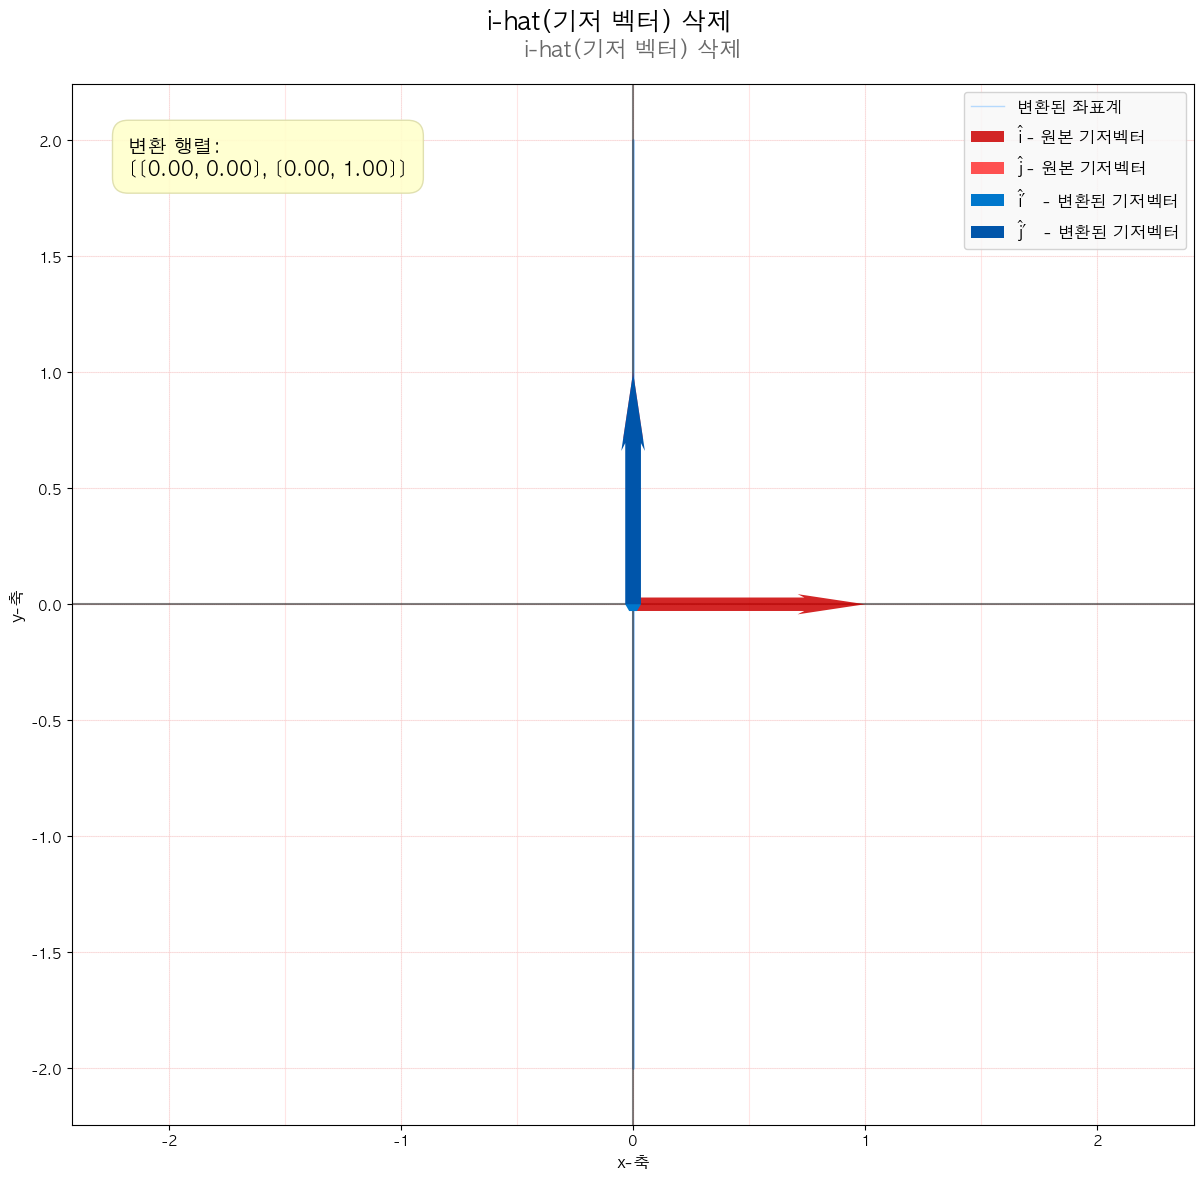

'animation_gifs' 폴더가 이미 존재합니다.
Saving animation to animation_gifs/rotation_30_animation.gif...
Animation saved successfully!
Saving animation to animation_gifs/asym_scaling_animation.gif...
Animation saved successfully!
Saving animation to animation_gifs/comb_animation.gif...
Animation saved successfully!
Saving animation to animation_gifs/zero_animation.gif...
Animation saved successfully!


In [18]:
def plot_grid(num_gridlines=8, grid_range=(-2, 2), color='lightgray', linewidth=0.5, alpha=0.5):
    """격자 그리기 함수"""
    grid_min, grid_max = grid_range
    grid_step = (grid_max - grid_min) / num_gridlines

    # 수직선 그리기
    for x in np.arange(grid_min, grid_max + grid_step, grid_step):
        plt.axvline(x, color=color, linewidth=linewidth, alpha=alpha)

    # 수평선 그리기
    for y in np.arange(grid_min, grid_max + grid_step, grid_step):
        plt.axhline(y, color=color, linewidth=linewidth, alpha=alpha)


def transform_grid(matrix, num_points=8, grid_range=(-2, 2), color='blue', linewidth=1, alpha=0.7, label=None):
    """
    행렬 변환을 적용한 격자 그리기 함수
    
    Parameters:
    -----------
    matrix: 변환 행렬 (2x2 NumPy 배열)
    num_points: 각 축마다 그릴 격자선 수
    grid_range: 격자의 범위 (min, max)
    color: 변환된 격자의 색상
    linewidth: 선 두께
    alpha: 투명도
    label: 범례 라벨
    """
    grid_min, grid_max = grid_range
    grid_step = (grid_max - grid_min) / num_points

    # 첫 번째 선에만 레이블 적용을 위한 플래그
    first_line = True

    # 수직선 변환
    for x in np.arange(grid_min, grid_max + grid_step, grid_step):
        points = np.array([[x, y] for y in np.linspace(grid_min, grid_max, 100)])
        transformed_points = np.array([matrix @ point for point in points])
        
        if first_line and label:
            plt.plot(transformed_points[:, 0], transformed_points[:, 1],
                     color=color, linewidth=linewidth, alpha=alpha, label=label)
            first_line = False
        else:
            plt.plot(transformed_points[:, 0], transformed_points[:, 1],
                     color=color, linewidth=linewidth, alpha=alpha)

    # 수평선 변환
    for y in np.arange(grid_min, grid_max + grid_step, grid_step):
        points = np.array([[x, y] for x in np.linspace(grid_min, grid_max, 100)])
        transformed_points = np.array([matrix @ point for point in points])
        plt.plot(transformed_points[:, 0], transformed_points[:, 1],
                 color=color, linewidth=linewidth, alpha=alpha)


def visualize_transformation(matrix, title="선형 변환"):
    """선형 변환의 효과를 시각화하는 함수"""
    plt.figure(figsize=(12, 12))

    # 좌표계 시각화 제목 추가
    plt.suptitle(title, fontsize=18, y=0.98, fontweight='bold')
    plt.title("빨간색 계열: 변환 전 좌표계 / 파란색 계열: 변환 후 좌표계", 
             fontsize=14, pad=20, color='dimgray')

    # 원본 격자 그리기 (i 벡터와 조화되는 연한 주황빛 색상으로)
    plot_grid(color=ORIGINAL_GRID_COLOR, alpha=0.5, linewidth=0.8)

    # 변환된 격자 그리기 (j 벡터와 조화되는 연한 파랑빛 색상으로)
    transform_grid(matrix, color=TRANSFORMED_GRID_COLOR, alpha=0.7, linewidth=1.0, label='변환된 좌표계')

    # 원래 기저 벡터 그리기 - 색상 구분 명확하게
    i_hat = np.array([1, 0])
    j_hat = np.array([0, 1])
    
    # 원본 기저 벡터 - 색상으로 구분하고 약간의 투명도 적용
    plot_vector2d(i_hat, color=ORIGINAL_I_COLOR, label=r'$\hat{i}$ - 원본 기저벡터', 
                  is_basis=True, alpha=0.85, width=0.012)
    plot_vector2d(j_hat, color=ORIGINAL_J_COLOR, label=r'$\hat{j}$ - 원본 기저벡터', 
                  is_basis=True, alpha=0.85, width=0.012)

    # 변환된 기저 벡터 그리기 - 원본과 유사하지만 더 진한 색상과 두꺼운 선으로
    transformed_i = matrix @ i_hat
    transformed_j = matrix @ j_hat
    plot_vector2d(transformed_i, color=TRANSFORMED_I_COLOR, label=r'$\hat{i}\prime$ - 변환된 기저벡터', 
                  is_basis=True, width=0.014, alpha=1.0)
    plot_vector2d(transformed_j, color=TRANSFORMED_J_COLOR, label=r'$\hat{j}\prime$ - 변환된 기저벡터', 
                  is_basis=True, width=0.014, alpha=1.0)

    # 축과 그리드 설정
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.5, linewidth=1.5)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.5, linewidth=1.5)
    
    # 좌표 라벨 추가
    plt.xlabel("x-축", fontsize=12)
    plt.ylabel("y-축", fontsize=12)

    # 변환 행렬을 텍스트로 표시 - 더 두드러진 배경으로, LaTeX 구문 수정
    matrix_text = f"변환 행렬:\n[[{matrix[0,0]:.2f}, {matrix[0,1]:.2f}], [{matrix[1,0]:.2f}, {matrix[1,1]:.2f}]]"
    plt.text(0.05, 0.95, matrix_text, transform=plt.gca().transAxes, 
             fontsize=14, verticalalignment='top', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='#FFFFCC', edgecolor='#DDDDAA', 
                      alpha=0.9, pad=0.8))

    # 범례와 제목 설정 - 폰트 크기 키우고 위치 조정, 범례 바탕 색상 더 뚜렷하게
    plt.title(title, fontsize=16, pad=20, fontweight='bold')
    plt.legend(loc='upper right', fontsize=12, framealpha=0.85, 
              facecolor='#F8F8F8', edgecolor='#CCCCCC')

    # 축 비율 동일하게 설정하고 표시
    plt.axis('equal')
    limit = max(abs(np.array(plt.axis()))) * 1.1
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)
    
    # 격자 추가 (약하게)
    plt.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# 애니메이션으로 변환 과정을 시각화하는 함수
def animate_transformation(matrix, frames=60, interval=50, title="Linear Transformation Animation", save_path=None):
    """
    Animate a linear transformation showing both vectors and grid lines changing
    
    Parameters:
    -----------
    matrix: 2x2 transformation matrix
    frames: Number of animation frames
    interval: Time between frames in milliseconds
    title: Animation title
    save_path: Path to save the animation (supports .gif, .mp4, etc.)
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Setup axis limits and style
    limit = 3.0
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_aspect('equal')
    ax.grid(alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Original basis vectors
    i_hat = np.array([1, 0])
    j_hat = np.array([0, 1])
    
    # Create quiver objects for the basis vectors
    i_arrow = ax.quiver(0, 0, i_hat[0], i_hat[1], angles='xy', scale_units='xy', scale=1, 
                     color=ORIGINAL_I_COLOR, width=0.008, alpha=0.9)
    j_arrow = ax.quiver(0, 0, j_hat[0], j_hat[1], angles='xy', scale_units='xy', scale=1,
                     color=ORIGINAL_J_COLOR, width=0.008, alpha=0.9)
    
    # Grid parameters
    num_gridlines = 8
    grid_range = (-2, 2)
    grid_min, grid_max = grid_range
    grid_step = (grid_max - grid_min) / num_gridlines
    
    # Create grid line collections that will be updated in the animation
    # We'll store all the line objects to update them in each frame
    original_vlines = []
    original_hlines = []
    transformed_vlines = []
    transformed_hlines = []
    
    # Draw original grid (these will remain static throughout the animation)
    for x in np.arange(grid_min, grid_max + grid_step, grid_step):
        vline, = ax.plot([x, x], [grid_min, grid_max], color=ORIGINAL_GRID_COLOR, 
                        linewidth=0.8, alpha=0.5, zorder=1)
        original_vlines.append(vline)
    
    for y in np.arange(grid_min, grid_max + grid_step, grid_step):
        hline, = ax.plot([grid_min, grid_max], [y, y], color=ORIGINAL_GRID_COLOR, 
                        linewidth=0.8, alpha=0.5, zorder=1)
        original_hlines.append(hline)
    
    # Create placeholder for transformed grid lines
    for x in np.arange(grid_min, grid_max + grid_step, grid_step):
        vline, = ax.plot([], [], color=TRANSFORMED_GRID_COLOR, 
                        linewidth=1.0, alpha=0.7, zorder=2)
        transformed_vlines.append(vline)
    
    for y in np.arange(grid_min, grid_max + grid_step, grid_step):
        hline, = ax.plot([], [], color=TRANSFORMED_GRID_COLOR, 
                       linewidth=1.0, alpha=0.7, zorder=2)
        transformed_hlines.append(hline)
    
    # Title and legend
    ax.set_title(title, fontsize=14)
    ax.legend([i_arrow, j_arrow], [r'$\hat{i}$ vector', r'$\hat{j}$ vector'], 
             loc='upper right', framealpha=0.9)
    
    # Add matrix text annotation
    matrix_text = ax.text(0.05, 0.95, "", transform=ax.transAxes, 
                        fontsize=12, verticalalignment='top', 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Update function for animation
    def update(frame):
        # Calculate interpolated transformation matrix
        t = frame / frames
        current_matrix = (1 - t) * np.eye(2) + t * matrix
        
        # Update basis vectors
        current_i = current_matrix @ i_hat
        current_j = current_matrix @ j_hat
        i_arrow.set_UVC(current_i[0], current_i[1])
        j_arrow.set_UVC(current_j[0], current_j[1])
        
        # Update transformed grid lines
        for i, x in enumerate(np.arange(grid_min, grid_max + grid_step, grid_step)):
            # Create vertical line points
            points = np.array([[x, y] for y in np.linspace(grid_min, grid_max, 100)])
            # Apply current transformation
            transformed_points = np.array([current_matrix @ point for point in points])
            # Update line data
            transformed_vlines[i].set_data(transformed_points[:, 0], transformed_points[:, 1])
        
        for i, y in enumerate(np.arange(grid_min, grid_max + grid_step, grid_step)):
            # Create horizontal line points
            points = np.array([[x, y] for x in np.linspace(grid_min, grid_max, 100)])
            # Apply current transformation
            transformed_points = np.array([current_matrix @ point for point in points])
            # Update line data
            transformed_hlines[i].set_data(transformed_points[:, 0], transformed_points[:, 1])
        
        # Update matrix text
        matrix_text.set_text(f"Current transformation matrix:\n[[{current_matrix[0,0]:.2f}, {current_matrix[0,1]:.2f}],\n [{current_matrix[1,0]:.2f}, {current_matrix[1,1]:.2f}]]")
        
        # Return all updated artists
        return [i_arrow, j_arrow] + transformed_vlines + transformed_hlines + [matrix_text]
    
    # Create animation (but don't display)
    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
    
    plt.tight_layout()
    
    if save_path:
        # Save animation (using appropriate writer)
        print(f"Saving animation to {save_path}...")
        writer = 'pillow' if save_path.endswith('.gif') else 'ffmpeg'
        anim.save(save_path, writer=writer, fps=30, dpi=100)
        print(f"Animation saved successfully!")
        
        # Close the figure to free up memory
        plt.close(fig)
    else:
        print("No save_path provided. Animation not saved.")
        
    return anim

# 예시: 회전 변환 (30도)
def rotation_matrix(theta_degrees):
    """각도(도)를 받아 회전 행렬을 반환하는 함수"""
    theta = np.radians(theta_degrees)
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])


# 예시: 확대/축소 변환
def scaling_matrix(scale_x, scale_y):
    """x축, y축 스케일 값을 받아 스케일링 행렬을 반환하는 함수"""
    return np.array([
        [scale_x, 0],
        [0, scale_y]
    ])


# 예시: 전단 변환 (Shear)
def shear_matrix(shear_x, shear_y):
    """x축, y축 전단 값을 받아 전단 행렬을 반환하는 함수"""
    return np.array([
        [1, shear_x],
        [shear_y, 1]
    ])


# 30도 회전 변환
rotation_30 = rotation_matrix(30)
visualize_transformation(rotation_30, "30도 회전 변환")

# 비대칭 스케일링 변환도 확인
scale_transform = scaling_matrix(1.5, 0.5)
visualize_transformation(scale_transform, "비대칭 스케일링 변환 (x: 1.5배, y: 0.5배)")

# 회전과 스케일링을 조합한 변환
combined_transform = rotation_30 @ scale_transform  # 행렬 곱을 통한 변환 조합
visualize_transformation(combined_transform, "회전(30도)과 스케일링(x: 1.5배, y: 0.5배)의 조합")

zero_transform = scaling_matrix(0, 1)
visualize_transformation(zero_transform, "i-hat(기저 벡터) 삭제")

# 애니메이션 저장 
import os

# 애니메이션을 저장할 폴더 경로 설정
output_folder = "animation_gifs"  # 폴더 이름 설정

# 폴더가 존재하지 않으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"'{output_folder}' 폴더가 생성되었습니다.")
else:
    print(f"'{output_folder}' 폴더가 이미 존재합니다.")

# 폴더 경로와 파일 이름을 조합하여 전체 경로 생성
rotation_gif_path = os.path.join(output_folder, "rotation_30_animation.gif")
scaling_gif_path = os.path.join(output_folder, "asym_scaling_animation.gif")
combined_gif_path = os.path.join(output_folder, "comb_animation.gif")
zero_gif_path = os.path.join(output_folder, "zero_animation.gif")

# 위에서 생성한 경로를 animate_transformation 함수의 save_path 매개변수에 전달
animate_transformation(rotation_30, frames=60, interval=50, 
                      title="30도 회전 변환 애니메이션", 
                      save_path=rotation_gif_path)

animate_transformation(scale_transform, frames=60, interval=50, 
                      title="비대칭 스케일링 변환 애니메이션", 
                      save_path=scaling_gif_path)

animate_transformation(combined_transform, frames=60, interval=50, 
                      title="회전과 스케일링을 조합한 변환 애니메이션", 
                      save_path=combined_gif_path)

animate_transformation(zero_transform, frames=60, interval=50, 
                      title="i-hat(기저 벡터) 삭제 변환 애니메이션", 
                      save_path=zero_gif_path)
